# 1. 소개

(1) Naver sentiment movie corpus 데이터를 9,999개의 트레이닝 세트와 9,999개의 테스트 세트를 가져왔다.  

(2) 각각의 세트에 toxic, obscene, threat, insult, identity_hate 로 레이블을 붙였다.  


 personal attacks model에 대한 주석의 기준은 [위키 참고](https://meta.wikimedia.org/wiki/Research:Detox/Data_Release)  

[관련 논문](https://arxiv.org/abs/1610.08914)  

[EDA참고 커널](https://www.kaggle.com/clinma/eda-toxic-comment-classification-challenge)  


[Keras 참고 커널](https://www.kaggle.com/vsmolyakov/keras-cnn-with-fasttext-embeddings/notebook)  

[캐글 대회 공식 홈페이지](https://www.kaggle.com)  

[데이터와 코드전체](https://drive.google.com/drive/u/0/folders/12xIOu6AjulYlF0TFkkgbU_qE5iqReA8a)  

[Naver sentiment movie corpus](https://github.com/e9t/nsmc)

# Introduction

In [49]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

%matplotlib inline

# Visualization
import seaborn as sns
from matplotlib import pyplot as plt

import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib_venn import venn3

from wordcloud import WordCloud

from collections import Counter
import re
import string
from nltk.corpus import stopwords

In [50]:

sns.set(style="white", context="talk")

In [51]:
#importing the dataset
df_train=pd.read_csv("./ko_data/ko_train_label.csv")
df_train.shape

(9999, 7)

In [52]:
df_test=pd.read_csv("./ko_data/ko_test.csv")
df_test.shape

(9999, 2)

In [53]:
df_train.tail()

,id,document,toxic,obscene,threat,insult,identity_hate
9994,7448293,혹시나 그래도 카메론디아즈니까 하고봤는데...먼이런영화를..이도저도아닌 .아암튼 시...,1,0,0,0,0
9995,5824024,10점주는것들 한국영화는 1점주네. M창,1,0,0,0,0
9996,6420437,영상도 아름답고 뭘 말하는지 알겠지만 그렇기 때문에 짜증나고 답답하다,1,0,0,0,0
9997,6777278,영화를 왜 영화라고 하는지 모르는 애들이 나왔네.,1,0,0,0,0
9998,9238637,내가 이걸보고 며칠내내 화가났네 별이 아깝 어쩜이리쓰래기가... 내용잡다한거 다섞여...,1,0,0,0,0


In [54]:
nrow_train = df_train.shape[0]
nrow_test = df_test.shape[0]
sum = nrow_train + nrow_test

print("       : train  : test")
print("row    :", nrow_train, ":", nrow_test)
print("ratio:", round(nrow_train*100/sum), "    :", round(nrow_test*100/sum))

       : train  : test
row    : 9999 : 9999
ratio: 50     : 50


### 악평이 아닌 데이터는 제외하고 시각화

In [55]:
COLUMNS = ['toxic', 'obscene', 'threat', 'insult', 'identity_hate']


# Adding 'none' columns if there is no '1' in COLUMNS
df_train['none'] = (df_train[COLUMNS].max(axis=1) == 0).astype(int)
COLUMNS.append('none')
CATEGORIES = COLUMNS.copy()


print(df_train.columns.values)

['id' 'document' 'toxic' 'obscene' 'threat' 'insult' 'identity_hate'
 'none']


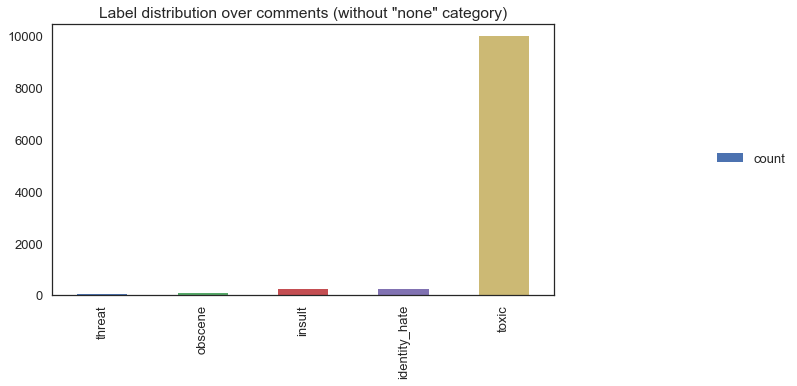

In [56]:
df_distribution = df_train[COLUMNS].sum()\
                            .to_frame()\
                            .rename(columns={0: 'count'})\
                            .sort_values('count')

df_distribution.drop('none').plot.bar(y='count',
                                      title='Label distribution over comments (without "none" category)',
                                      figsize=(9, 5))\
                            .legend(loc='center left', bbox_to_anchor=(1.3, 0.5))

In [57]:
df_distribution.sort_values('count', ascending=False)

,count
toxic,9969
identity_hate,261
insult,225
obscene,95
threat,33
none,29


주요 레이블



In [58]:
df_comb = df_train.groupby(COLUMNS)\
                    .size()\
                    .sort_values(ascending=False)\
                    .reset_index()\
                    .rename(columns={0: 'count'})
df_comb.head(n=10)

,toxic,obscene,threat,insult,identity_hate,none,count
0,1,0,0,0,0,0,9507
1,1,0,0,0,1,0,153
2,1,0,0,1,0,0,104
3,1,0,0,1,1,0,82
4,1,1,0,0,0,0,62
5,0,0,0,0,0,1,29
6,1,1,0,1,0,0,16
7,1,0,1,0,0,0,12
8,1,1,0,1,1,0,10
9,1,0,1,0,1,0,6


'none'이 86061 개로 가장 많다.  
 
최초의 '실제'라벨 인 '악평'은 1 단계에서 6 단계까지 모든 조합으로 제공된다.  

이 6 개의 행에서 'obscene'은 4 번 나타난다.  

각 조합에 대한 댓글은 기하 급수적으로 감소하고 있다.

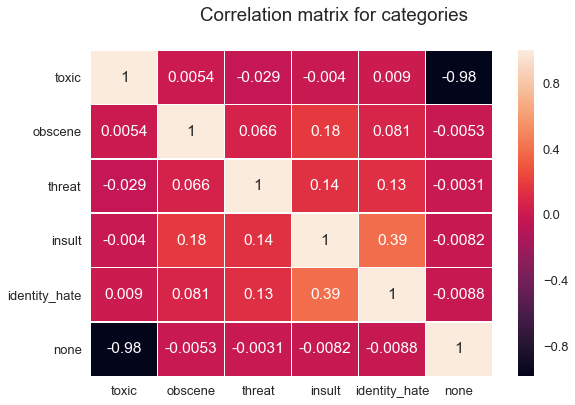

In [59]:
f, ax = plt.subplots(figsize=(9, 6))
f.suptitle('Correlation matrix for categories')
sns.heatmap(df_train[COLUMNS].corr(), annot=True, linewidths=.5, ax=ax)

위의 매트리스를 통해 알 수 있는 것은   

1. 'toxic' is clearly correlated with 'obscene' and 'insult' (0.68 and 0.65)  

2. 'toxic' and 'severe_toxic' are only got a 0.31 correlation factor    

3. 'insult' and 'obscene' have a correlation factor of 0.74


따라서 몇 가지 조합은 좀 더 살펴 보아야 함


1. 'toxic' <-> 'severe_toxic'. The semantic of these two categories seems to show some kind of graduation between them  

2. 'toxic' <-> 'insult' and 'toxic' <-> 'obscene'  

3. 'insult' <-> 'obscene'

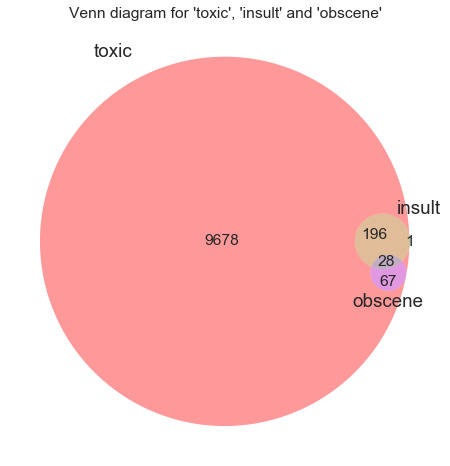

In [60]:
t = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 0)].shape[0]
i = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]

t_i = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 0)].shape[0]
t_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 0) & (df_train['obscene'] == 1)].shape[0]
i_o = df_train[(df_train['toxic'] == 0) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]

t_i_o = df_train[(df_train['toxic'] == 1) & (df_train['insult'] == 1) & (df_train['obscene'] == 1)].shape[0]


# Make the diagram
plt.figure(figsize=(8, 8))
plt.title("Venn diagram for 'toxic', 'insult' and 'obscene'")
venn3(subsets = (t, i, t_i, o, t_o, i_o, t_i_o), 
      set_labels=('toxic', 'insult', 'obscene'))
plt.show()

1.  'insult' 와 'obscene' 'toxic'으로 레이블 되어 있지 않은 경우는 매우 적다.
 
 
 2. 3,610개의 코멘트가 3개의 범주에 겹쳐서 레이블 되어 있다. 

'toxic' 과 'severe_toxic'만 벤다이어그램으로 좀 더 살펴 보자.

1. 'severe_toxic'카테고리는 'toxic에 완전히 포함되어 있고 두 카테고리 이름 역시 의미론적 연관되어 있다.    

2. 0.31 correlation factor은 'severe_toxic'이 'toxic'의 작은 비율 (11.67 %)을 차지한다는 사실을 설명한다.


1. 총 길이는 글 쓴이에 (좋은 방법이나 나쁜 것 중 하나로)어떤 함의를 나타낼 수 있다.  

2. 총 carriage 리턴 수는 주석에 일종의 구조를 나타낼 수 있다.  

# Keras CNN with Fasttext Embeddings

윈도우에 Keras설치 및 데이터 과적합 등에 관한 내용은 이태영님 블로그 참고. 


https://tykimos.github.io/2017/03/25/Dataset_and_Fit_Talk/

한국어 위키피디아의 Pre-trained word 벡터는 다음 싸이트에서 다운로드 할 수 있다. vectors(https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md)  

Mac OS와 Linux 환경이고 실전에서 fasttext 워드 벡터도 조정해야 한다면 [이기창님 블로그를 참고] https://ratsgo.github.io/from%20frequency%20to%20semantics/2017/07/06/fasttext/

In [127]:
import keras
from keras import optimizers
from keras import backend as K
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten
from keras.layers import Embedding, Conv1D, MaxPooling1D, GlobalMaxPooling1D 
from keras.utils import plot_model
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer
from keras.callbacks import EarlyStopping

from tqdm import tqdm
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs



In [128]:
sns.set_style("whitegrid")
np.random.seed(0)
     
DATA_PATH = './data'
EMBEDDING_DIR = './'

MAX_NB_WORDS = 100000
tokenizer = RegexpTokenizer(r'\w+')


In [129]:
from subprocess import check_output
print(check_output(["ls", "./"]).decode("utf8"))

en_data
heatmap_test.ipynb
ko_data
toxic_comment_EDA_KERAS.ipynb
네이버 영화평_toxic_comment_EDA_KERAS.ipynb



In [130]:
#load embeddings
print('loading word embeddings...')
embeddings_index = {}
f = codecs.open('./ko_data/wiki.ko.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(embeddings_index))

757it [00:00, 7567.86it/s]

loading word embeddings...


879131it [01:51, 7856.82it/s]

found 879130 word vectors


num train:  9999
num test:  9999


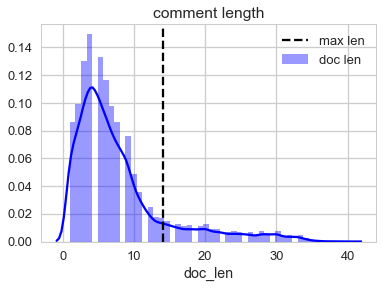

In [131]:
#load data
train_df = pd.read_csv('./ko_data' + '/ko_train_label.csv', sep=',', header=0)
test_df = pd.read_csv('./ko_data' + '/ko_test.csv', sep=',', header=0)
test_df = test_df.fillna('_NA_')

print("num train: ", train_df.shape[0])
print("num test: ", test_df.shape[0])

label_names = ["toxic", "obscene", "threat", "insult", "identity_hate"]
y_train = train_df[label_names].values

#visualize word distribution
train_df['doc_len'] = train_df['document'].apply(lambda words: len(words.split(" ")))
max_seq_len = np.round(train_df['doc_len'].mean() + train_df['doc_len'].std()).astype(int)
sns.distplot(train_df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('comment length'); plt.legend()
plt.show()

In [132]:
raw_docs_train = train_df['document'].tolist()
raw_docs_test = test_df['document'].tolist() 
num_classes = len(label_names)

print("pre-processing train data...")
processed_docs_train = []
for doc in tqdm(raw_docs_train):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_train.append(" ".join(filtered))
#end for

processed_docs_test = []
for doc in tqdm(raw_docs_test):
    tokens = tokenizer.tokenize(doc)
    filtered = [word for word in tokens if word not in stop_words]
    processed_docs_test.append(" ".join(filtered))
#end for

print("tokenizing input data...")
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, lower=True, char_level=False)
tokenizer.fit_on_texts(processed_docs_train + processed_docs_test)  #leaky
word_seq_train = tokenizer.texts_to_sequences(processed_docs_train)
word_seq_test = tokenizer.texts_to_sequences(processed_docs_test)
word_index = tokenizer.word_index
print("dictionary size: ", len(word_index))

#pad sequences
word_seq_train = sequence.pad_sequences(word_seq_train, maxlen=max_seq_len)
word_seq_test = sequence.pad_sequences(word_seq_test, maxlen=max_seq_len)

100%|██████████| 9999/9999 [00:00<00:00, 152976.62it/s]

pre-processing train data...



100%|██████████| 9999/9999 [00:00<00:00, 180399.20it/s]


tokenizing input data...
dictionary size:  64341


In [133]:
#training params
batch_size = 256 
num_epochs = 8 

#model parameters
num_filters = 64 
embed_dim = 300 
weight_decay = 1e-4

In [134]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(embedding_matrix, axis=1) == 0))

preparing embedding matrix...
number of null word embeddings: 39328


In [135]:
print("sample words not found: ", np.random.choice(words_not_found, 10))

sample words not found:  ['ㅜㅡ' '제대로안봤다' '훨씬났다' '찍는다했을' '롤러브레이드' '챙겨봤었는데' '작품일듯' '또오랜만' '눈치깐다'
 '욕바가지']


In [136]:
#CNN architecture
print("training CNN ...")
model = Sequential()
model.add(Embedding(nb_words, embed_dim,
          weights=[embedding_matrix], input_length=max_seq_len, trainable=False))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(MaxPooling1D(2))
model.add(Conv1D(num_filters, 7, activation='relu', padding='same'))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(weight_decay)))
model.add(Dense(num_classes, activation='sigmoid'))  #multi-label (k-hot encoding)

adam = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='binary_crossentropy', optimizer=adam, metrics=['accuracy'])
model.summary()

training CNN ...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 14, 300)           19302300  
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 14, 64)            134464    
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 7, 64)             0         
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 7, 64)             28736     
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 64)                0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 32)                2080

학습이 과적합되는 것을 막기 위해 학습을 조기 종료한다.

In [137]:
#define callbacks
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0.01, patience=4, verbose=1)
callbacks_list = [early_stopping]

In [138]:
#model training

hist = model.fit(word_seq_train, y_train, batch_size=batch_size, epochs=num_epochs, callbacks=callbacks_list, validation_split=0.1, shuffle=True, verbose=2)

Train on 8999 samples, validate on 1000 samples
Epoch 1/8
 - 3s - loss: 0.2619 - acc: 0.9319 - val_loss: 0.1531 - val_acc: 0.9834
Epoch 2/8
 - 2s - loss: 0.1191 - acc: 0.9874 - val_loss: 0.1030 - val_acc: 0.9834
Epoch 3/8
 - 2s - loss: 0.0867 - acc: 0.9875 - val_loss: 0.0827 - val_acc: 0.9834
Epoch 4/8
 - 2s - loss: 0.0716 - acc: 0.9875 - val_loss: 0.0784 - val_acc: 0.9834
Epoch 5/8
 - 2s - loss: 0.0663 - acc: 0.9875 - val_loss: 0.0783 - val_acc: 0.9834
Epoch 6/8
 - 2s - loss: 0.0641 - acc: 0.9875 - val_loss: 0.0776 - val_acc: 0.9834
Epoch 7/8
 - 2s - loss: 0.0610 - acc: 0.9875 - val_loss: 0.0811 - val_acc: 0.9834
Epoch 00007: early stopping


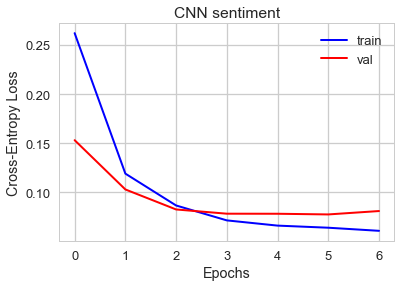

In [140]:
#generate plots
plt.figure()
plt.plot(hist.history['loss'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_loss'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Cross-Entropy Loss')
plt.legend(loc='upper right')
plt.show()

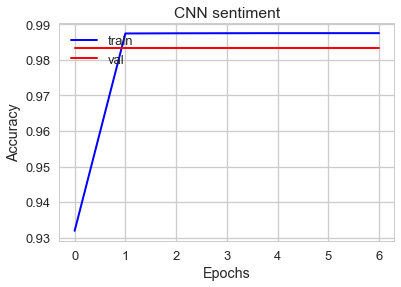

In [141]:
plt.figure()
plt.plot(hist.history['acc'], lw=2.0, color='b', label='train')
plt.plot(hist.history['val_acc'], lw=2.0, color='r', label='val')
plt.title('CNN sentiment')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')
plt.show()

References:  

[1] P. Bojanowski, E. Grave, A. Joulin, T. Mikolov, "Enriching Word Vectors with Subword Information", arXiv, 2016
[2] FastText Embeddings: https://github.com/facebookresearch/fastText/blob/master/pretrained-vectors.md
[3] F. Chollet, "Deep Learning with Python", Manning Publications, 2017